<a href="https://colab.research.google.com/github/erinmcmahon26/NLP-Chat-Bot/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports, define functions, and ingest data

In [3]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from collections import Counter
from dataclasses import dataclass

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

In [4]:
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

Python library for topic modeling, document indexing, and similarity retrieval with large corpora. 

In [5]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [6]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


In [7]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()    

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def add_flags(data: pd.DataFrame, the_conjuring_doc_ids: List[int], horror_doc_ids: List[int]):
    data['is_the_conjuring'] = data.index.isin(the_conjuring_doc_ids)
    data['is_horror'] = data.index.isin(horror_doc_ids)
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

Full class corpus of move reviews stored on class github.

In [8]:
CORPUS_PATH = 'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_Sec57_2202_ClassCorpus_v2.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]
print(documents[0])
print(type(documents))

Document(doc_id=191, text='Is this where we are at? Is this the state of the nation? Bring back the cold war and let\'s dump this Bond into the rubbish bin of America\'s world paranoia. Because that\'s whets happened, Bond has been hijacked by the Yankee Doodle dandy with a cob on! In every Bond from on her Majesty\'s secret service to Golden Eye there has been more than a passing nod in the direction of the Fleming novels, and although the plot of the film sticks tersely to the novels outline, its modern interpretation is like fitting a square peg into a round hole. Craig\'s bond is the proverbial hammer, for whom every problem seems to be a nail, this was a real chance to expose an audience to Flemings insight into the Bond character, his reasons for returning to the service are complicated and full of pathos, made all the more acute by Vespers suicide. Now i\'m not one of those nuts that says a film should be like the book, not in the least, they are two distinct and separate forms 

### EDA for Selected Movie Review (The Conjuring 3)

In [9]:
corpus_df.shape

(200, 8)

In [10]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 191 to 75
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Student Name              200 non-null    object
 2   Genre of Movie            200 non-null    object
 3   Review Type (pos or neg)  200 non-null    object
 4   Movie Title               200 non-null    object
 5   Text                      200 non-null    object
 6   Descriptor                200 non-null    object
 7   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 14.1+ KB


In [11]:
corpus_df.head()

,DSI_Title,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Text,Descriptor,Doc_ID
Doc_ID,,,,,,,,
191,JLU_Doc1_JamesBondCasinoRoyale,JLU,Action,Negative,"James Bond, Casino Royale",Is this where we are at? Is this the state of ...,"Action_James Bond, Casino Royale_N_191",191
192,JLU_Doc2_JamesBondCasinoRoyale,JLU,Action,Negative,"James Bond, Casino Royale","Give or take the odd Octopussy, I suppose, lik...","Action_James Bond, Casino Royale_N_192",192
193,JLU_Doc3_JamesBondCasinoRoyale,JLU,Action,Negative,"James Bond, Casino Royale",The James Bond films have been with us for mor...,"Action_James Bond, Casino Royale_N_193",193
194,JLU_Doc4_JamesBondCasinoRoyale,JLU,Action,Negative,"James Bond, Casino Royale",The introduction of a new James Bond always br...,"Action_James Bond, Casino Royale_N_194",194
195,JLU_Doc5_JamesBondCasinoRoyale,JLU,Action,Negative,"James Bond, Casino Royale",Although box office has remained strong worldw...,"Action_James Bond, Casino Royale_N_195",195


In [12]:
# assess number of reviews by genre and creating a df
counts_df = corpus_df[['Genre of Movie']].copy()
counts_df.value_counts()

Genre of Movie
Comedy            60
Horror            50
Sci-Fi            50
Action            40
dtype: int64

In [13]:
counts_df['Count'] = 1
counts_df.groupby(['Genre of Movie']).count().reset_index()

,Genre of Movie,Count
0,Action,40
1,Comedy,60
2,Horror,50
3,Sci-Fi,50


In [14]:
# assess movie titles
corpus_df['Movie Title'].value_counts()

James Bond, Casino Royale                                 10
Mission Impossible Fallout                                10
The Martian                                               10
Interstellar                                              10
Guardians of the Galaxy                                   10
Arrival                                                   10
Us                                                        10
The Ring                                                  10
The Conjuring 3                                           10
Lamb                                                      10
Hereditary                                                10
The Grand Budapest Hotel                                  10
Spider Man 3                                              10
Red Notice                                                10
Frozen II                                                 10
Encanto                                                   10
Cruella                 

In [15]:
# look up documents using different columns 

titles_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Movie Title'])}
genres_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Genre of Movie'])}
descriptors_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Descriptor'])}

print(titles_by_doc_ids)
print(genres_by_doc_ids)
print(descriptors_by_doc_ids)

{191: 'James Bond, Casino Royale', 192: 'James Bond, Casino Royale', 193: 'James Bond, Casino Royale', 194: 'James Bond, Casino Royale', 195: 'James Bond, Casino Royale', 196: 'James Bond, Casino Royale', 197: 'James Bond, Casino Royale', 198: 'James Bond, Casino Royale', 199: 'James Bond, Casino Royale', 200: 'James Bond, Casino Royale', 16: 'Mission Impossible Fallout', 17: 'Mission Impossible Fallout', 18: 'Mission Impossible Fallout', 19: 'Mission Impossible Fallout', 20: 'Mission Impossible Fallout', 11: 'Mission Impossible Fallout', 12: 'Mission Impossible Fallout', 13: 'Mission Impossible Fallout', 14: 'Mission Impossible Fallout', 15: 'Mission Impossible Fallout', 86: 'Pirates of the Caribbean: The Curse of the Black Pearl', 87: 'Pirates of the Caribbean: The Curse of the Black Pearl', 88: 'Pirates of the Caribbean: The Curse of the Black Pearl', 89: 'Pirates of the Caribbean: The Curse of the Black Pearl', 90: 'Pirates of the Caribbean: The Curse of the Black Pearl', 81: 'Pira

In [16]:
# collect all horror documents
horror_doc_ids = [int(x) for x in corpus_df['Doc_ID'] if genres_by_doc_ids[x] == 'Horror']
horror_documents = [x for x in documents if x.doc_id in horror_doc_ids]

In [17]:
# collect all non horror documents
non_horror_doc_ids = {int(x) for x in corpus_df['Doc_ID'] if genres_by_doc_ids[x] != 'Horror'}
non_horror_documents = [x for x in documents if x.doc_id in non_horror_doc_ids]

Standardize All Documents: remove punctuation, lower case, remove tags, and remove special characters and #s. 

In [18]:
normalized_documents = normalize_documents(documents)
print(type(normalized_documents))
print(normalized_documents[0])

<class 'list'>
Document(doc_id=191, text='is this where we are at is this the state of the nation bring back the cold war and let s dump this bond into the rubbish bin of america s world paranoia because that s whets happened bond has been hijacked by the yankee doodle dandy with a cob on in every bond from on her majesty s secret service to golden eye there has been more than a passing nod in the direction of the fleming novels and although the plot of the film sticks tersely to the novels outline its modern interpretation is like fitting a square peg into a round hole craig s bond is the proverbial hammer for whom every problem seems to be a nail this was a real chance to expose an audience to flemings insight into the bond character his reasons for returning to the service are complicated and full of pathos made all the more acute by vespers suicide now i m not one of those nuts that says a film should be like the book not in the least they are two distinct and separate forms and sh

Tokenize all the normalized docs

In [19]:
tokenized_documents = tokenize_documents(normalized_documents)
print(type(tokenized_documents))
print(tokenized_documents[0])

<class 'list'>
TokenizedDocument(doc_id=191, tokens=['is', 'this', 'where', 'we', 'are', 'at', 'is', 'this', 'the', 'state', 'of', 'the', 'nation', 'bring', 'back', 'the', 'cold', 'war', 'and', 'let', 's', 'dump', 'this', 'bond', 'into', 'the', 'rubbish', 'bin', 'of', 'america', 's', 'world', 'paranoia', 'because', 'that', 's', 'whets', 'happened', 'bond', 'has', 'been', 'hijacked', 'by', 'the', 'yankee', 'doodle', 'dandy', 'with', 'a', 'cob', 'on', 'in', 'every', 'bond', 'from', 'on', 'her', 'majesty', 's', 'secret', 'service', 'to', 'golden', 'eye', 'there', 'has', 'been', 'more', 'than', 'a', 'passing', 'nod', 'in', 'the', 'direction', 'of', 'the', 'fleming', 'novels', 'and', 'although', 'the', 'plot', 'of', 'the', 'film', 'sticks', 'tersely', 'to', 'the', 'novels', 'outline', 'its', 'modern', 'interpretation', 'is', 'like', 'fitting', 'a', 'square', 'peg', 'into', 'a', 'round', 'hole', 'craig', 's', 'bond', 'is', 'the', 'proverbial', 'hammer', 'for', 'whom', 'every', 'problem', 'se

In [20]:
# create code for looking at my movie reviews (the conjuring)
the_conjuring_doc_ids = [int(x) for x in corpus_df['Doc_ID'] if titles_by_doc_ids[x] == 'The Conjuring 3']
the_conjuring_documents = [x for x in documents if x.doc_id in the_conjuring_doc_ids]
type(the_conjuring_documents)

list

In [21]:
conjuring_norm = normalize_documents(the_conjuring_documents)
conjuring_norm[0]

Document(doc_id=1, text='i must admit that when i sat down to watch the addition to the conjuring franchise i was not harboring much of any overly great expectations or hopes because since the first movie it has been a steady downward slope still as i had the chance to sit down and watch the conjuring the devil made me do it from writers david leslie johnson mcgoldrick and james wan so of course i did it and i have to say that director michael chaves managed to deliver a movie that was only slightly entertaining the conjuring the devil made me do it was a whole lot of nothing going on and you can essentially just watch the beginning and the last minutes of the movie and skip on everything in between the storyline written for the conjuring the devil made me do it was bland and slow paced with very little of much excitement or interest happening in between the start and the end of the movie and that ultimately led to a less than mediocre movie experience for me and yeah i am a horror vet

In [22]:
conjuring_token = tokenize_documents(conjuring_norm)
print(conjuring_token[0])
print(type(conjuring_token))


TokenizedDocument(doc_id=1, tokens=['i', 'must', 'admit', 'that', 'when', 'i', 'sat', 'down', 'to', 'watch', 'the', 'addition', 'to', 'the', 'conjuring', 'franchise', 'i', 'was', 'not', 'harboring', 'much', 'of', 'any', 'overly', 'great', 'expectations', 'or', 'hopes', 'because', 'since', 'the', 'first', 'movie', 'it', 'has', 'been', 'a', 'steady', 'downward', 'slope', 'still', 'as', 'i', 'had', 'the', 'chance', 'to', 'sit', 'down', 'and', 'watch', 'the', 'conjuring', 'the', 'devil', 'made', 'me', 'do', 'it', 'from', 'writers', 'david', 'leslie', 'johnson', 'mcgoldrick', 'and', 'james', 'wan', 'so', 'of', 'course', 'i', 'did', 'it', 'and', 'i', 'have', 'to', 'say', 'that', 'director', 'michael', 'chaves', 'managed', 'to', 'deliver', 'a', 'movie', 'that', 'was', 'only', 'slightly', 'entertaining', 'the', 'conjuring', 'the', 'devil', 'made', 'me', 'do', 'it', 'was', 'a', 'whole', 'lot', 'of', 'nothing', 'going', 'on', 'and', 'you', 'can', 'essentially', 'just', 'watch', 'the', 'beginning

### Selecting Relavent (Qualitative) Terms

In [23]:
# selected from term extraction notebook
candidate_terms = ['conjuring', 'film', 'made', 'devil', 'horror',
                   'movie','warren','series','chaves','franchise']

In [24]:
vectorizer = CountVectorizer(ngram_range=(1,1))
text_for_counts = [x.text for x in normalized_documents]
matrix = vectorizer.fit_transform(text_for_counts)
words = vectorizer.get_feature_names_out()
word_counts = pd.DataFrame(matrix.toarray(), columns = words, index = corpus_df.Doc_ID)
word_counts.head()

,aaah,abandon,abandoned,abandoning,abandonment,abandons,abashed,abba,abbott,abby,...,zooming,zoomy,zoot,zootopia,zora,zorro,zorros,zubrowka,zweig,zz
Doc_ID,,,,,,,,,,,,,,,,,,,,,
191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
add_flags(word_counts, the_conjuring_doc_ids, horror_doc_ids)
word_counts['Doc_ID'] = word_counts.index

In [26]:
mean_frequencies = pd.DataFrame(index=candidate_terms)

the_conjuring_mean_frequencies = word_counts[word_counts.is_the_conjuring][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['The Conjuring'] = the_conjuring_mean_frequencies

horror_mean_frequencies = word_counts[word_counts.is_horror][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['All Horror'] = horror_mean_frequencies

non_horror_mean_frequencies = word_counts[~word_counts.is_horror][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['All Non-Horror'] = non_horror_mean_frequencies

In [27]:
mean_frequencies.fillna(0.0).sort_values(['The Conjuring'], ascending=False)

,The Conjuring,All Horror,All Non-Horror
conjuring,6.9,1.42,0.000000
film,5.7,5.10,3.933333
made,5.3,1.54,0.840000
devil,5.2,1.14,0.086667
horror,3.9,3.20,0.053333
movie,3.4,3.22,2.966667
series,2.9,0.60,0.560000
chaves,2.8,0.56,0.000000
franchise,2.7,0.54,0.586667
warren,1.8,0.36,0.000000


In [28]:
important_prevalent_terms = ['conjuring','film','made','devil']

#### EDA Method 1: Baseline cleaning, normalization, and tokenization

In [29]:
def Baseline_clean_method(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
           
    return documents

In [42]:
def run_tfidf(documents: List[Document],
              clean_func: Callable[[List[Document]], List[TokenizedDocument]],
              important_prevalent_terms: List[str],
              experiment_name: str,
              output_tfidf_vectors: bool=False,
              output_vocabulary: bool=True):
    cleaned_documents = clean_func(documents)
    cleaned_document_text = [' '.join(x.tokens) for x in cleaned_documents]
    
    vectorizer = TfidfVectorizer(use_idf=True,
                                 ngram_range=(1, 1),
                                 norm=None)

    transformed_documents = vectorizer.fit_transform(cleaned_document_text)
    transformed_documents_as_array = transformed_documents.toarray()

    output_dir = f'output/{experiment_name}_Results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if output_tfidf_vectors:
        for counter, doc in enumerate(transformed_documents_as_array):
            tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
            one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score'])\
                                        .sort_values(by='score', ascending=False)\
                                        .reset_index(drop=True)

            one_doc_as_df.to_csv(f'{output_dir}/{corpus_df["Submission File Name"][counter]}')
    
    if output_vocabulary:
        with open(f'{output_dir}/vocabulary.txt', 'w') as vocab:
            words = sorted(vectorizer.get_feature_names_out())
            print('\n'.join(words), file=vocab)

    # Create document-term dataframe
    doc_term_matrix = transformed_documents.todense()
    doc_term_df = pd.DataFrame(doc_term_matrix, 
                               columns=vectorizer.get_feature_names_out(), 
                               index=corpus_df.Doc_ID)
    add_flags(doc_term_df, the_conjuring_doc_ids, horror_doc_ids)
    
    # Print the top 10 mean TF-IDF values
    top10_tfidf = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(10))
    top10_tfidf.rename(columns={0: 'Mean TF-IDF'}, inplace=True)
    display(top10_tfidf)
    
    # Collect result into a dataframe
    tfidf_results = pd.DataFrame(index=important_prevalent_terms)
 
    all_tfidf_results = doc_term_df[[x for x in important_prevalent_terms if x in doc_term_df.columns]].mean().round(2)
    tfidf_results['All Movies'] = all_tfidf_results
    display(tfidf_results)
    
    plt.hist(doc_term_df.mean(), 100, range=(0, 8))
    
    print(f'Vocabulary size: {doc_term_df.shape[1]}')
    
    descriptors = corpus_df['Descriptor']
       
    similarities = cosine_similarity(doc_term_df.loc[horror_doc_ids], doc_term_df.loc[horror_doc_ids])
    fig, ax = plt.subplots(figsize=(30, 30))
    labels = [descriptors_by_doc_ids[x.doc_id] for x in horror_documents]
    sns.heatmap(ax=ax, data=similarities, xticklabels=labels, yticklabels=labels)
    #plt.savefig(f'figures/{experiment_name}_heatmap_documents.png')
    plt.show()

,Mean TF-IDF
the,48.535000
of,23.375000
and,22.435000
to,20.085000
in,13.880000
is,12.610000
that,11.160501
it,10.940000
as,7.727266
with,7.484101


,All Movies
conjuring,1.33
film,4.93
made,1.67
devil,1.09


Vocabulary size: 15869


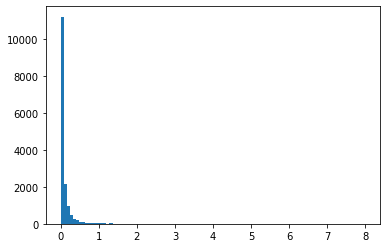

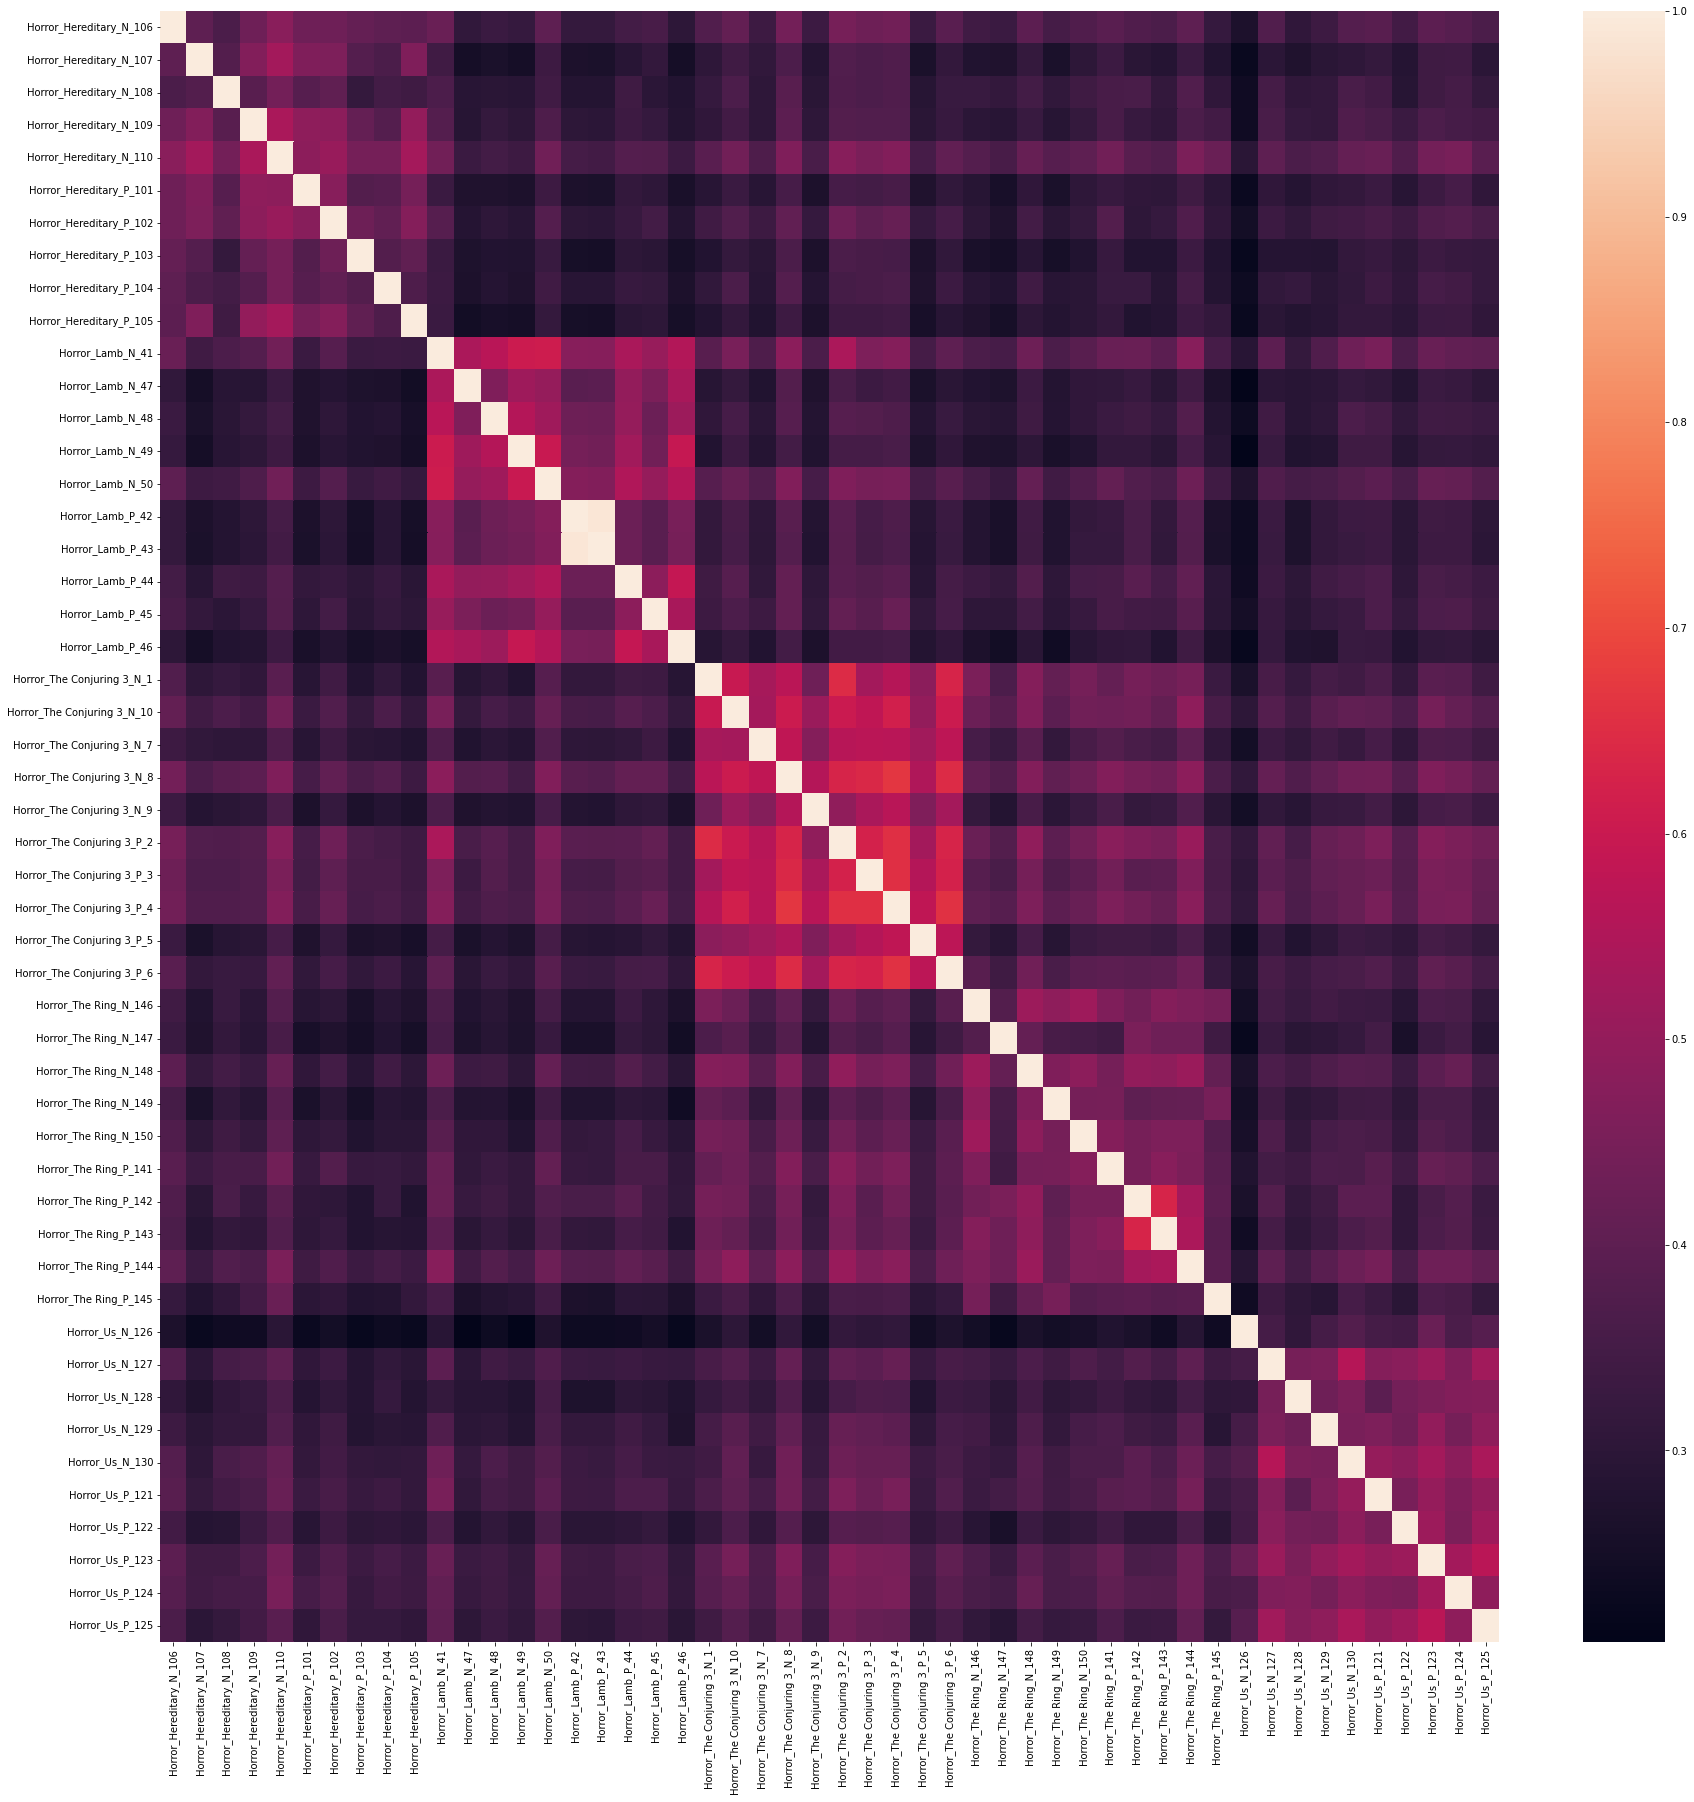

In [43]:
run_tfidf(documents, Baseline_clean_method, important_prevalent_terms, 'Baseline_TFIDF_Scores')

The histogram is very skewed.
Every row = row vector - can calculate cos similarity with these vectors. 
This is showing that the Ring reviews aren't very similar, let's see if we can fix that with additional EDA. In general, we are not seeing very high similarities with each movie and it's reviews. My theory is this will get better once we take away the stop words. 

#### EDA Method 2: Baseline cleaning, normalization, tokenization, remove stop words, and stemming

In [44]:
def clean_method_2(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes, lemmatizes, and removes stop words.
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
    documents = stem(documents)
    documents = remove_stop_words(documents)
            
    return documents

,Mean TF-IDF
film,5.777984
hi,5.310194
thi,4.985646
bond,4.703754
movi,4.663324
cruella,3.866356
one,3.558666
wa,3.312443
like,3.208267
ha,3.112222


,All Movies
conjuring,NaN
film,5.78
made,1.67
devil,1.09


Vocabulary size: 10520


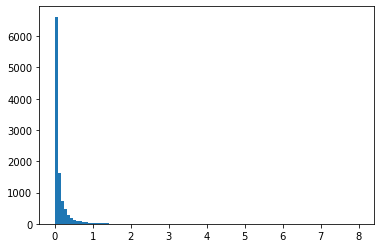

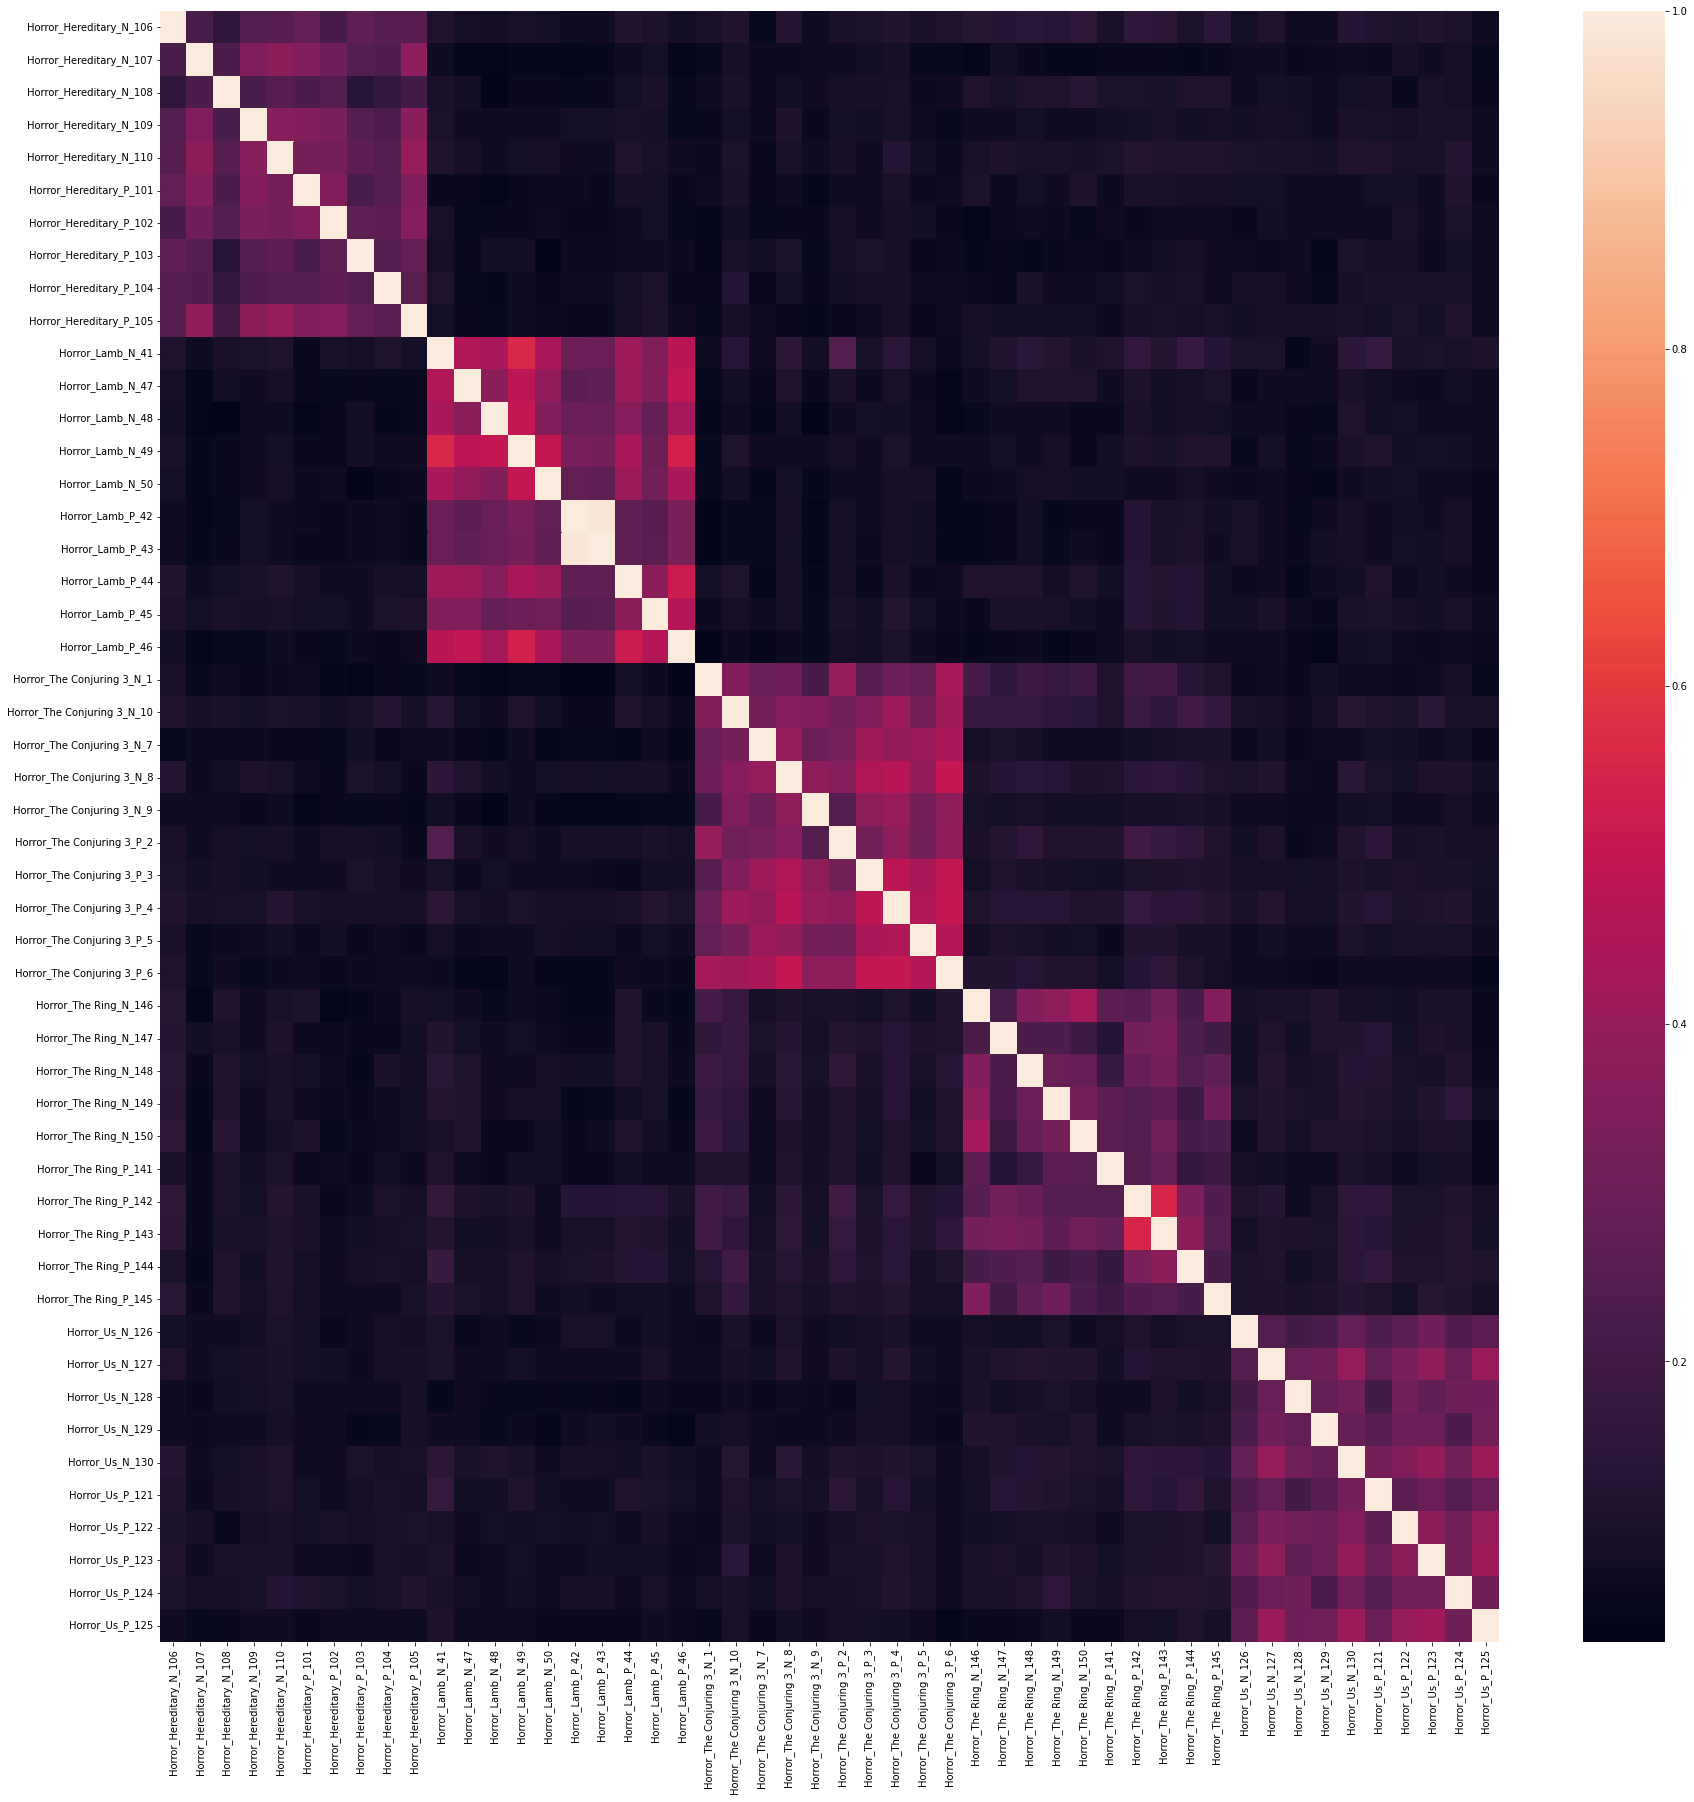

In [45]:
run_tfidf(documents, clean_method_2, important_prevalent_terms, 'Method_2_TF_IDF')

Here we have more distinct areas of correlation within movie reviews. We still have a few odd correlations here and there so we will try another method to see if we can get cleaner results. 

#### EDA Method 3: Baseline cleaning, normalization, tokenization, remove stop words, stemming, and lemmatization

In [50]:
def clean_method_3(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes, lemmatizes, and removes stop words.
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
    documents = lemmatize(documents)
    documents = remove_stop_words(documents)
        
    return documents

,Mean TF-IDF
film,5.738135
bond,4.799233
movie,4.663324
cruella,3.866356
one,3.558666
wa,3.312443
ha,3.112222
like,3.037983
anderson,2.481302
character,2.428730


,All Movies
conjuring,1.33
film,5.74
made,1.67
devil,1.09


Vocabulary size: 14068


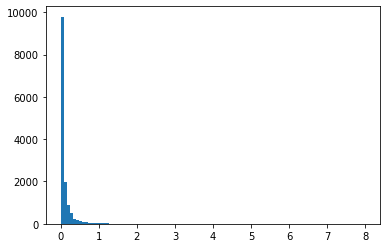

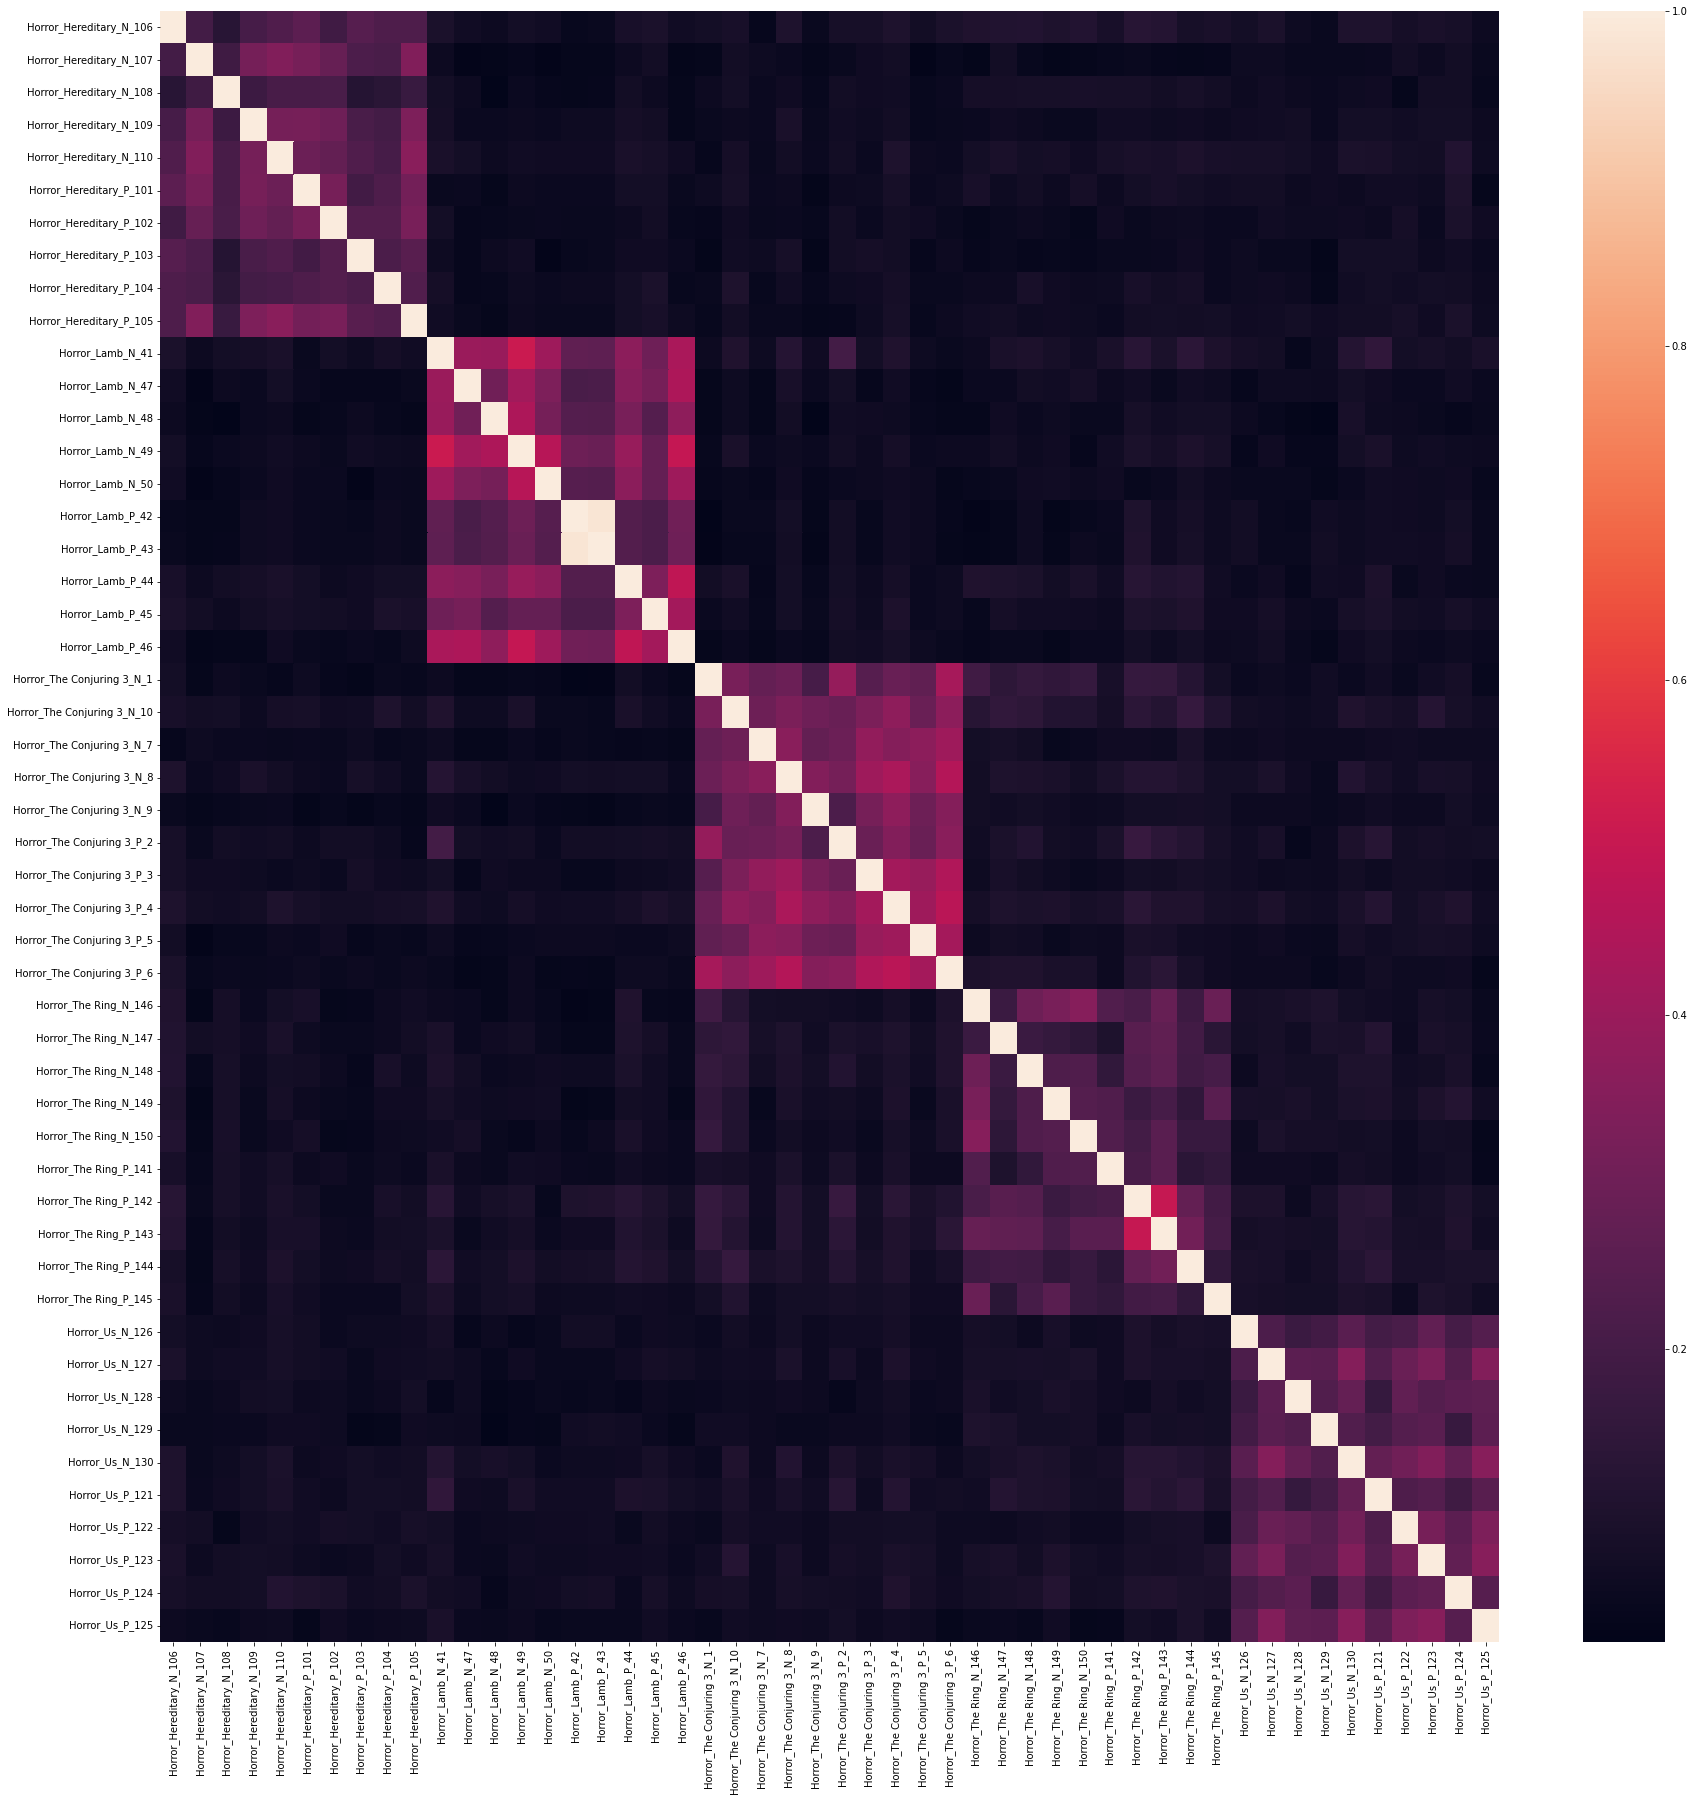

In [51]:
run_tfidf(documents, clean_method_3, important_prevalent_terms, 'Method_3_TF-IDF')

In [52]:
def clean_method_3_1(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes, lemmatizes, and removes stop words.
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
    documents = lemmatize(documents)
    documents = remove_stop_words(documents)
    documents = stem(documents)
        
    return documents

,Mean TF-IDF
film,5.777984
bond,4.703754
movi,4.663324
cruella,3.866356
one,3.558666
wa,3.312443
like,3.208267
ha,3.112222
anderson,2.481302
charact,2.428730


,All Movies
conjuring,NaN
film,5.78
made,1.67
devil,1.09


Vocabulary size: 10503


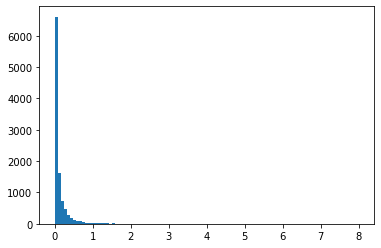

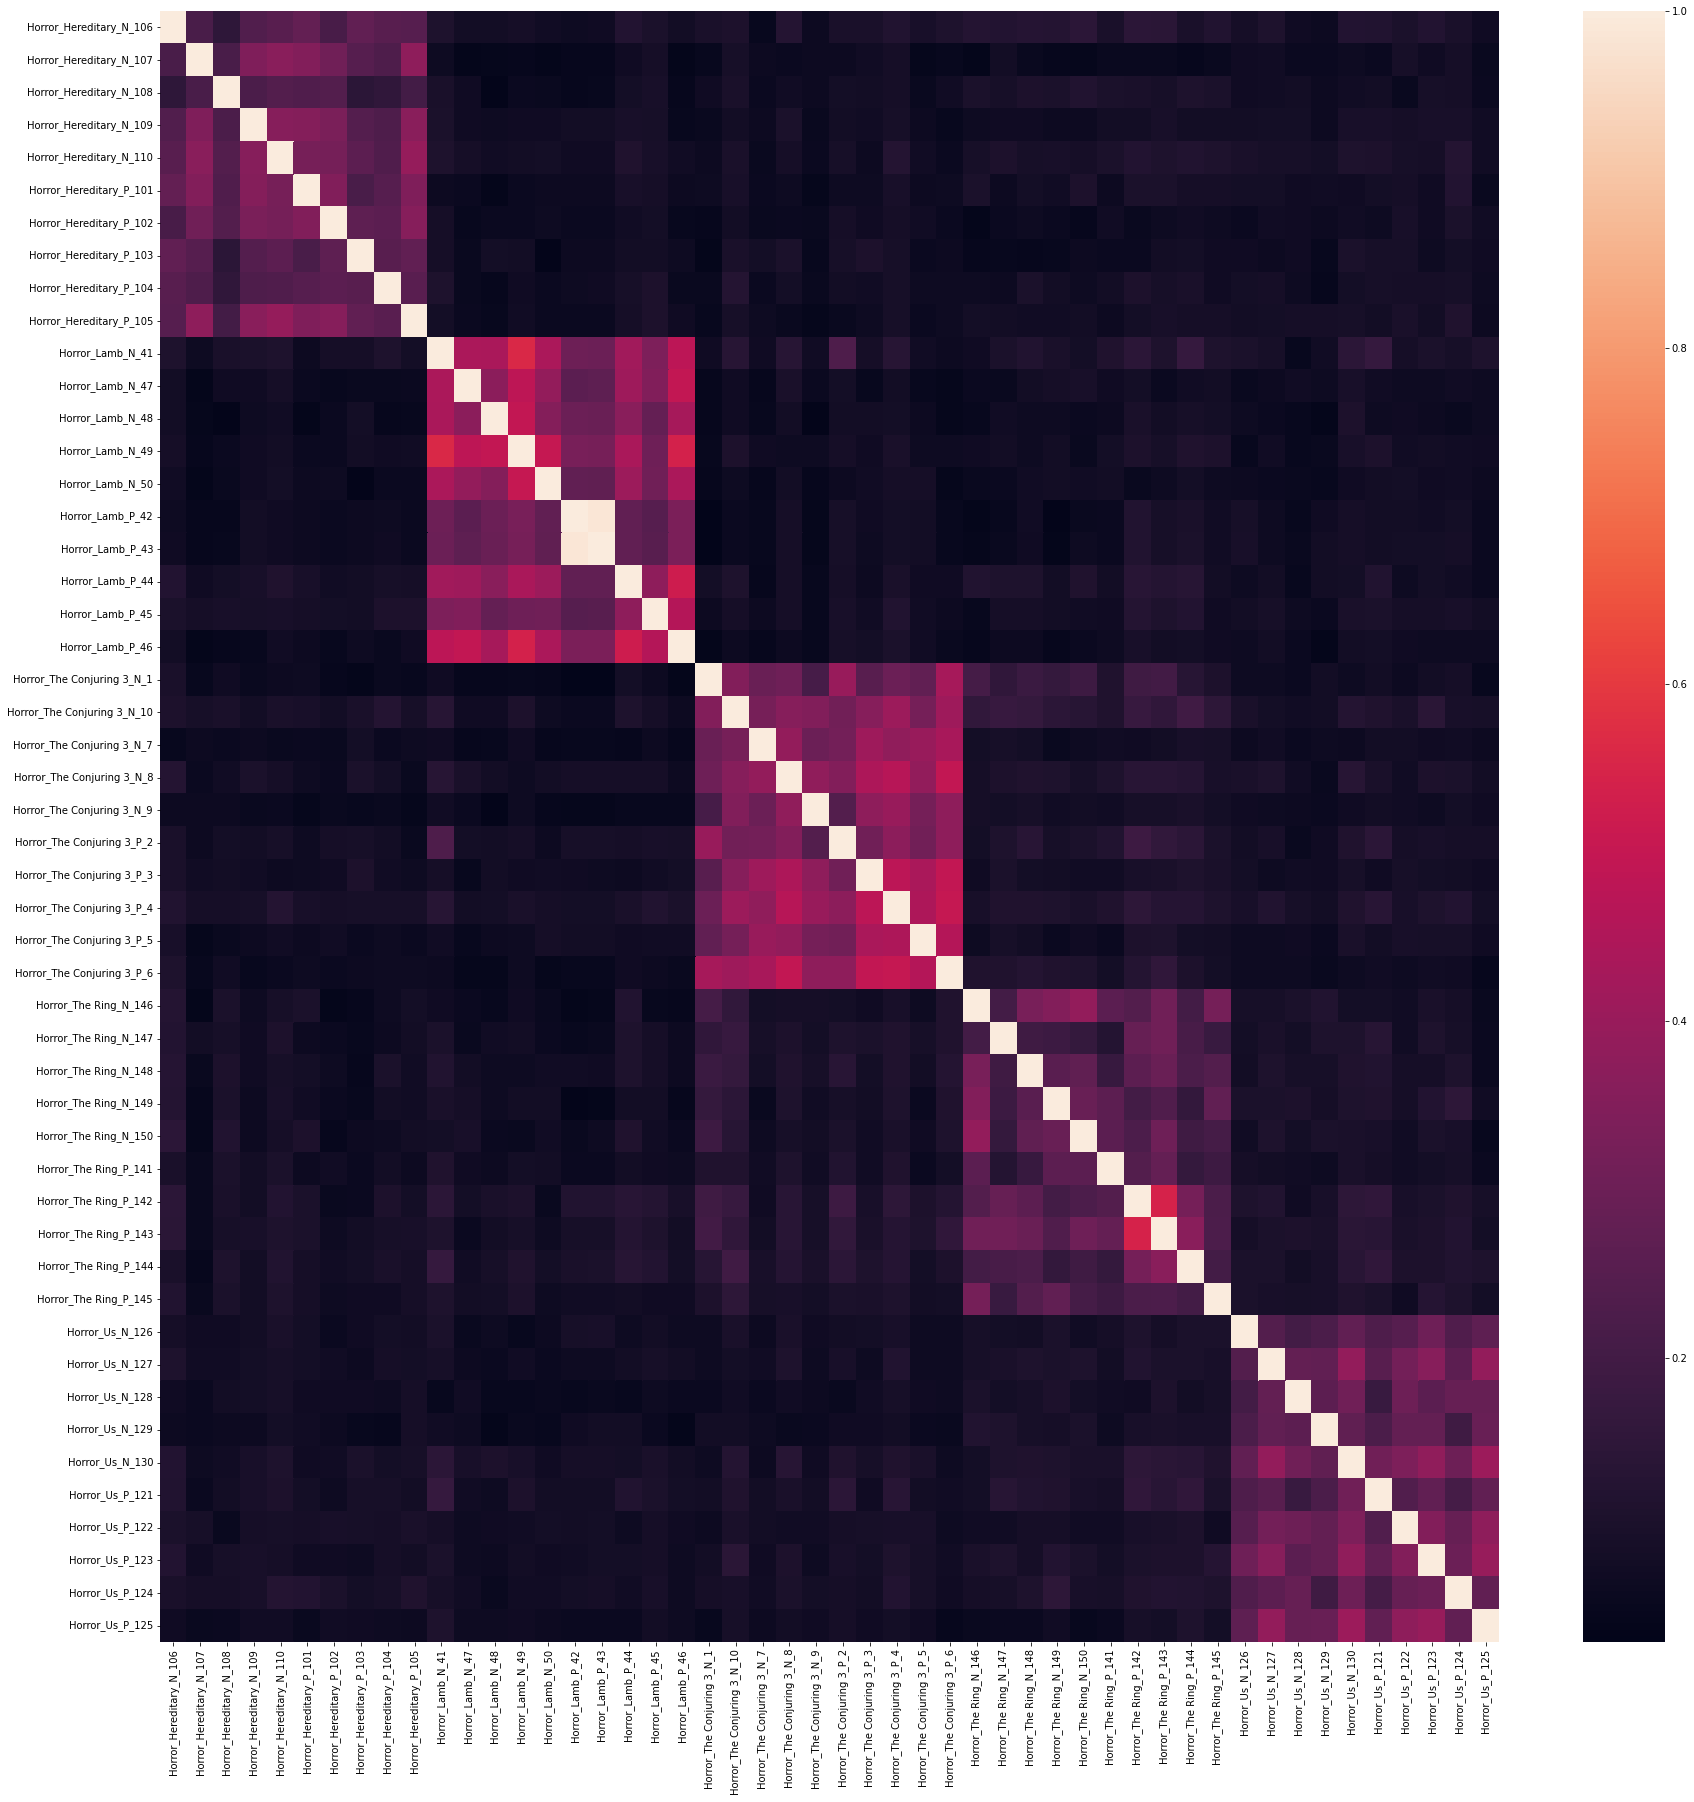

In [54]:
run_tfidf(documents, clean_method_3_1, important_prevalent_terms, 'Medof3.1_TF_IDF')

There isn't a huge difference between using stemming + lemmatization versus just using lemmatization. The biggest difference is when using both, conjuring does produces a NaN TF-IFT value for all docs. The best approach may be to just apply lemmatization for now. We will see if it needs to be adjusted down the line. 